# Datathon Group 18

In [1]:
# Import the Pandas package
import pandas as pd
# Import the NumPy package
import numpy as np
# Import the Data functions
import data as d
# Import the DateTime functions
import datetime as DT

import geopandas as gp
import seaborn as sns
import matplotlib.pyplot as plt
import folium

from shapely.geometry import Polygon
from shapely.ops import nearest_points
from shapely.geometry import Point
from shapely.geometry import shape

In [2]:
#Create a list of the files to work with
# lstFiles = ["uber_trips_2014.csv","uber_trips_2015.csv","green_trips.csv","yellow_trips.csv"]
# Load the files as a DataFrames

#lstDataFrames=[]

#Loading the trips dataframes
dfU14 = d.dataLoader("uber_trips_2014.csv")
dfU15 = d.dataLoader("uber_trips_2015.csv")
dfGC = d.dataLoader("green_trips.csv")
dfYC = d.dataLoader("yellow_trips.csv")

#Let's add symbols in case we want to merge and differentiate the registers by source
dfU14['Symbol'] = 'U14'
dfU15['Symbol'] = 'U15'
dfGC['Symbol'] = 'GCT'
dfYC['Symbol'] = 'YCT'


In [3]:
#Load the dataframe with the MTA trips
dfMTA = d.dataLoader('mta_trips.csv')
dfMTA['Symbol'] = 'MTA'

/Users/IAM/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
#Loading the supplementary dataframes
dfDemo = d.dataLoader("demographics.csv")
dfGeo = d.dataLoader('geographic.csv')
dfZones = d.dataLoader('zones.csv')
df_weather=d.dataLoader('weather.csv')

In [5]:
#Let's check what are the date ranges. Focused on the car sources
d.viewRange("--uber 2014--","pickup_datetime",dfU14)
d.viewRange("--uber 2015--","pickup_datetime",dfU15)
d.viewRange("--GC--","pickup_datetime",dfGC)
d.viewRange("--YC--","pickup_datetime",dfYC)

--uber 2014--
Min:4/1/14 0:00
Max:9/9/2014 9:59:00
--uber 2015--
Min:2015-01-01 00:00:05
Max:2015-06-30 23:59:00
--GC--
Min:2014-04-01 00:00:00
Max:2015-06-30 23:59:57
--YC--
Min:2014-04-01 00:00:00
Max:2015-06-30 23:59:59


In [6]:
#IAM: fixing rogue dates in the Uber 2014 dataframes
dfU14['pickup_datetime'] = pd.to_datetime(dfU14['pickup_datetime'], infer_datetime_format=True)

In [7]:
#We create date and hour columns for the different Dataframes as a way to be able to group the data at a later stage
dfU14['TIME'] = pd.DatetimeIndex(dfU14['pickup_datetime']).hour
dfU14['DATE'] = pd.DatetimeIndex(dfU14['pickup_datetime']).date

dfU15['TIME'] = pd.DatetimeIndex(dfU15['pickup_datetime']).hour
dfU15['DATE'] = pd.DatetimeIndex(dfU15['pickup_datetime']).date

dfGC['TIME'] = pd.DatetimeIndex(dfGC['pickup_datetime']).hour
dfGC['DATE'] = pd.DatetimeIndex(dfGC['pickup_datetime']).date

dfYC['TIME'] = pd.DatetimeIndex(dfYC['pickup_datetime']).hour
dfYC['DATE'] = pd.DatetimeIndex(dfYC['pickup_datetime']).date

In [16]:
#Now the different data structures are visualized to see what datatypes are used in order to compare apples with apples
print(dfDemo.info())
print(dfDemo.describe())
print("null values demographics: \n ")
print(dfDemo.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 33 columns):
nta_name            188 non-null object
borough             188 non-null object
nta_code            188 non-null object
population          188 non-null int64
under_5_years       188 non-null int64
5-9_years           188 non-null int64
10-14_years         188 non-null int64
15-19_years         188 non-null int64
20-24_years         188 non-null int64
25-29_years         188 non-null int64
30-34_years         188 non-null int64
35-39_years         188 non-null int64
40-44_years         188 non-null int64
45-49_years         188 non-null int64
50-54_years         188 non-null int64
55-59_years         188 non-null int64
60-64_years         188 non-null int64
over_65_years       188 non-null int64
median_age          188 non-null int64
people_per_acre     188 non-null float64
households          188 non-null int64
less_than_10,000    188 non-null int64
10000_to_14999      188 non-null

## Visualization

**Demographics**

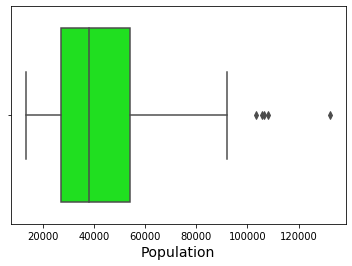

In [18]:
#Visualize different aspects from the Demographics data

sns.boxplot(x=dfDemo['population'], color='lime')
plt.xlabel('Population', fontsize=14)
plt.show()

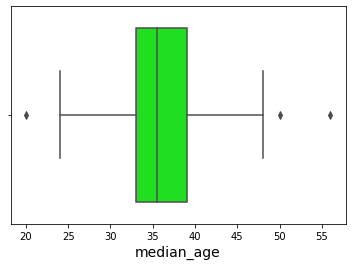

In [20]:
sns.boxplot(x=dfDemo['median_age'], color='lime')
plt.xlabel('median_age', fontsize=14)
plt.show()

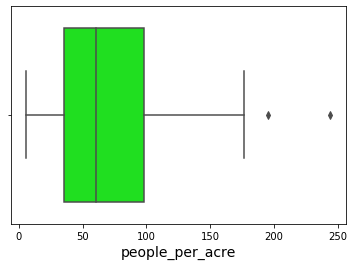

In [21]:
sns.boxplot(x=dfDemo['people_per_acre'], color='lime')
plt.xlabel('people_per_acre', fontsize=14)
plt.show()

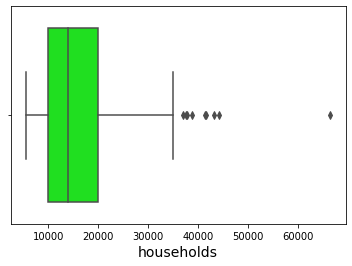

In [22]:
sns.boxplot(x=dfDemo['households'], color='lime')
plt.xlabel('households', fontsize=14)
plt.show()

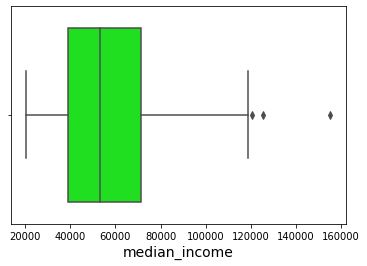

In [23]:
sns.boxplot(x=dfDemo['median_income'], color='lime')
plt.xlabel('median_income', fontsize=14)
plt.show()

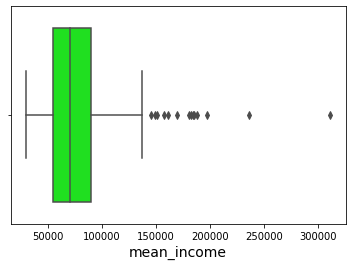

In [24]:
sns.boxplot(x=dfDemo['mean_income'], color='lime')
plt.xlabel('mean_income', fontsize=14)
plt.show()

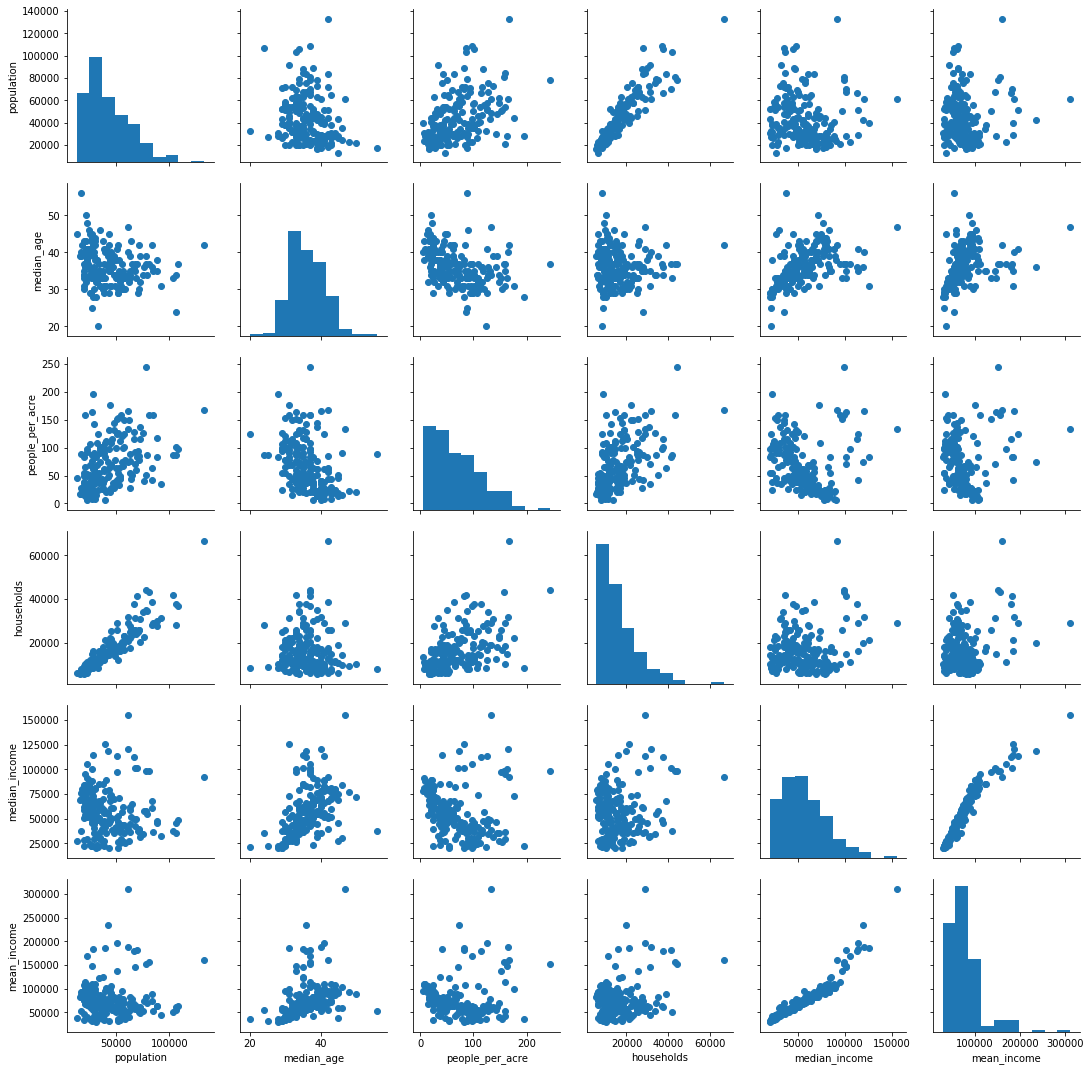

In [25]:
df_demographics_plot=dfDemo[['population','median_age','people_per_acre','households',
                                                    'median_income','mean_income']]
x=sns.PairGrid(df_demographics_plot)
x=x.map_diag(plt.hist)
x=x.map_offdiag(plt.scatter)

**Green cab trips**

In [26]:
print(dfGC.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589048 entries, 0 to 3589047
Data columns (total 12 columns):
pickup_datetime      object
dropoff_datetime     object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
trip_distance        float64
total_amount         float64
Symbol               object
TIME                 int64
DATE                 object
dtypes: float64(6), int64(2), object(4)
memory usage: 328.6+ MB
None


In [27]:
print(dfGC.describe())

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count      3.589048e+06     3.589048e+06       3.589048e+06      3.589048e+06   
mean      -7.381415e+01     4.068699e+01      -7.382658e+01      4.069179e+01   
std        2.976375e+00     1.641374e+00       2.812674e+00      1.550998e+00   
min       -1.223996e+02     0.000000e+00      -1.223996e+02      0.000000e+00   
25%       -7.395853e+01     4.070282e+01      -7.396718e+01      4.070625e+01   
50%       -7.394424e+01     4.074771e+01      -7.394400e+01      4.075044e+01   
75%       -7.391512e+01     4.080492e+01      -7.390833e+01      4.079577e+01   
max        0.000000e+00     4.278692e+01       0.000000e+00      4.316054e+01   

       passenger_count  trip_distance  total_amount          TIME  
count     3.589048e+06   3.589048e+06  3.589048e+06  3.589048e+06  
mean      1.404419e+00   2.949620e+00  1.478221e+01  1.359364e+01  
std       1.094672e+00   2.980152e+00  2.977614e+01  6.846637e+00 

In [54]:
print("null values in green cab trips: \n ")
print(dfGC.isna().sum())

null values in green cab trips: 
 
pickup_datetime      0
dropoff_datetime     0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
trip_distance        0
total_amount         0
Symbol               0
TIME                 0
DATE                 0
dtype: int64


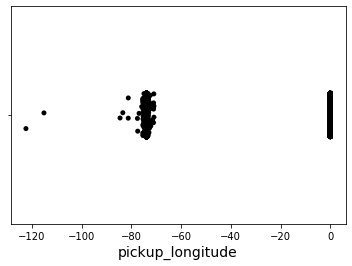

In [32]:
sns.stripplot(x=dfGC['pickup_longitude'], color='black')
plt.xlabel('pickup_longitude', fontsize=14)
plt.show()

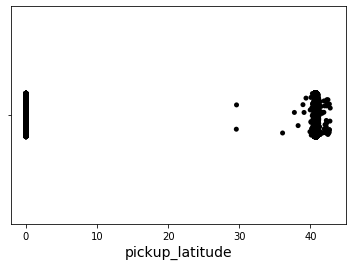

In [33]:
sns.stripplot(x=dfGC['pickup_latitude'], color='black')
plt.xlabel('pickup_latitude', fontsize=14)
plt.show()

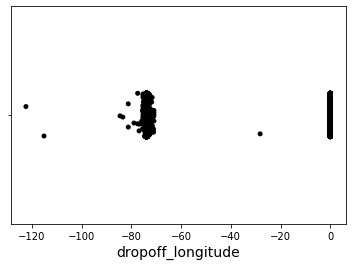

In [35]:
sns.stripplot(x=dfGC['dropoff_longitude'], color='black')
plt.xlabel('dropoff_longitude', fontsize=14)
plt.show()

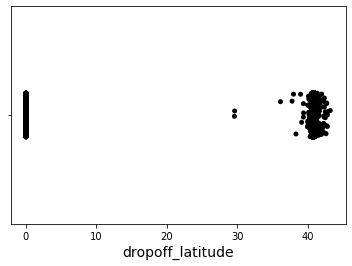

In [36]:
sns.stripplot(x=dfGC['dropoff_latitude'], color='black')
plt.xlabel('dropoff_latitude', fontsize=14)
plt.show()

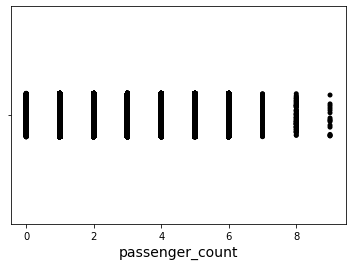

In [37]:
sns.stripplot(x=dfGC['passenger_count'], color='black')
plt.xlabel('passenger_count', fontsize=14)
plt.show()

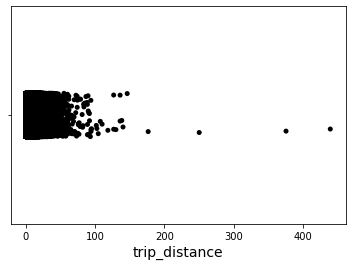

In [38]:
sns.stripplot(x=dfGC['trip_distance'], color='black')
plt.xlabel('trip_distance', fontsize=14)
plt.show()

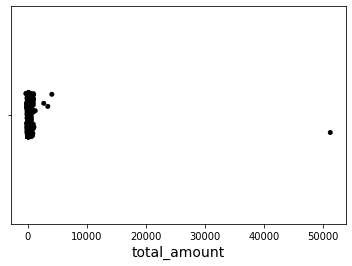

In [39]:
sns.stripplot(x=dfGC['total_amount'], color='black')
plt.xlabel('total_amount', fontsize=14)
plt.show()

**Yellow cab trips**

In [40]:
print(dfYC.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7974059 entries, 0 to 7974058
Data columns (total 12 columns):
pickup_datetime      object
dropoff_datetime     object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
trip_distance        float64
total_amount         float64
Symbol               object
TIME                 int64
DATE                 object
dtypes: float64(6), int64(2), object(4)
memory usage: 730.0+ MB
None


In [41]:
print(dfYC.describe())

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count      7.974059e+06     7.974059e+06       7.974059e+06      7.974059e+06   
mean      -7.244694e+01     3.990894e+01      -7.246507e+01      3.991985e+01   
std        1.052101e+01     5.796364e+00       1.046042e+01      5.763262e+00   
min       -1.800000e+02    -1.800000e+02      -7.364167e+02     -1.800000e+02   
25%       -7.399203e+01     4.073474e+01      -7.399137e+01      4.073344e+01   
50%       -7.398172e+01     4.075247e+01      -7.397979e+01      4.075291e+01   
75%       -7.396661e+01     4.076706e+01      -7.396233e+01      4.076824e+01   
max        1.720110e+02     6.220818e+01       1.720110e+02      4.043000e+02   

       passenger_count  trip_distance  total_amount          TIME  
count     7.974059e+06   7.974059e+06  7.974059e+06  7.974059e+06  
mean      1.688382e+00   1.659788e+01  1.560997e+01  1.352616e+01  
std       1.346068e+00   1.063671e+04  1.347520e+01  6.518469e+00 

In [53]:
print("null values in yellow cab trips: \n ")
print(dfYC.isna().sum())

null values in yellow cab trips: 
 
pickup_datetime      0
dropoff_datetime     0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
trip_distance        0
total_amount         0
Symbol               0
TIME                 0
DATE                 0
dtype: int64


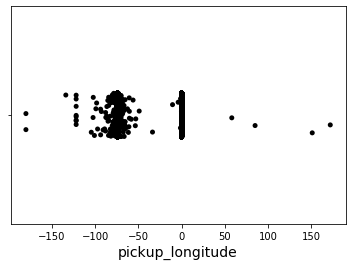

In [43]:
sns.stripplot(x=dfYC['pickup_longitude'], color='black')
plt.xlabel('pickup_longitude', fontsize=14)
plt.show()

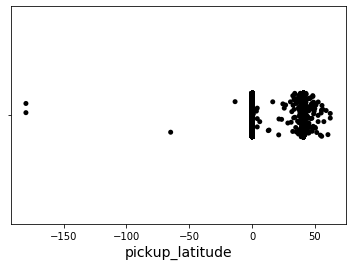

In [44]:
sns.stripplot(x=dfYC['pickup_latitude'], color='black')
plt.xlabel('pickup_latitude', fontsize=14)
plt.show()

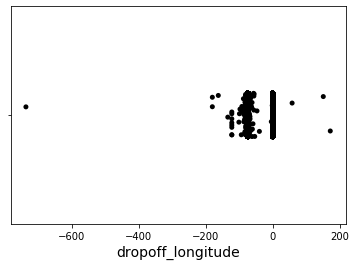

In [45]:
sns.stripplot(x=dfYC['dropoff_longitude'], color='black')
plt.xlabel('dropoff_longitude', fontsize=14)
plt.show()

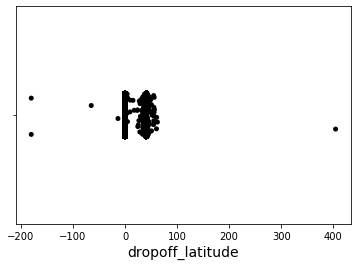

In [46]:
sns.stripplot(x=dfYC['dropoff_latitude'], color='black')
plt.xlabel('dropoff_latitude', fontsize=14)
plt.show()

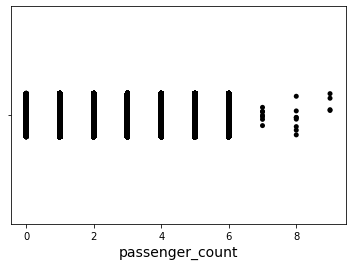

In [47]:
sns.stripplot(x=dfYC['passenger_count'], color='black')
plt.xlabel('passenger_count', fontsize=14)
plt.show()

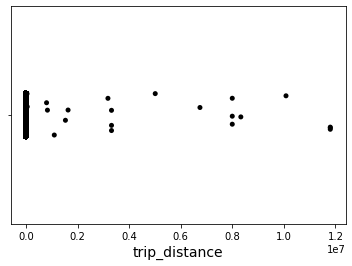

In [48]:
sns.stripplot(x=dfYC['trip_distance'], color='black')
plt.xlabel('trip_distance', fontsize=14)
plt.show()

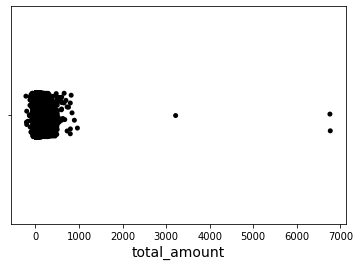

In [49]:
sns.stripplot(x=dfYC['total_amount'], color='black')
plt.xlabel('total_amount', fontsize=14)
plt.show()

**Uber 2014 trips**

In [50]:
print(dfU14.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 7 columns):
pickup_datetime     datetime64[ns]
pickup_latitude     float64
pickup_longitude    float64
base                object
Symbol              object
TIME                int64
DATE                object
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 242.2+ MB
None


In [51]:
print(dfU14.describe())

       pickup_latitude  pickup_longitude          TIME
count     4.534327e+06      4.534327e+06  4.534327e+06
mean      4.073926e+01     -7.397302e+01  1.421831e+01
std       3.994991e-02      5.726670e-02  5.958759e+00
min       3.965690e+01     -7.492900e+01  0.000000e+00
25%       4.072110e+01     -7.399650e+01  1.000000e+01
50%       4.074220e+01     -7.398340e+01  1.500000e+01
75%       4.076100e+01     -7.396530e+01  1.900000e+01
max       4.211660e+01     -7.206660e+01  2.300000e+01


In [55]:
print("null values in uber trips - 2014: \n ")
print(dfU14.isna().sum())

null values in uber trips - 2014: 
 
pickup_datetime     0
pickup_latitude     0
pickup_longitude    0
base                0
Symbol              0
TIME                0
DATE                0
dtype: int64


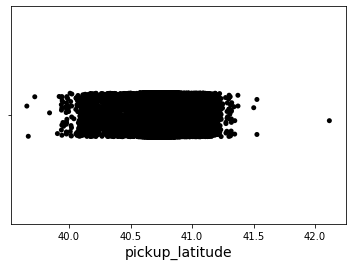

In [56]:
sns.stripplot(x=dfU14['pickup_latitude'], color='black')
plt.xlabel('pickup_latitude', fontsize=14)
plt.show()

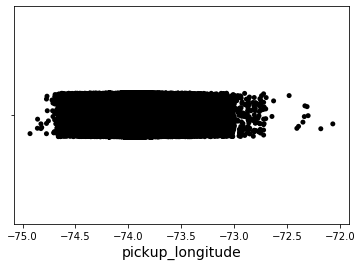

In [58]:
sns.stripplot(x=dfU14['pickup_longitude'], color='black')
plt.xlabel('pickup_longitude', fontsize=14)
plt.show()

**Uber 2015 trips**

In [59]:
print(dfU15.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14270479 entries, 0 to 14270478
Data columns (total 7 columns):
pickup_datetime       object
pickup_location_id    int64
dispatch_base         object
affiliate_base        object
Symbol                object
TIME                  int64
DATE                  object
dtypes: int64(2), object(5)
memory usage: 762.1+ MB
None


In [60]:
print(dfU15.describe())

       pickup_location_id          TIME
count        1.427048e+07  1.427048e+07
mean         1.520574e+02  1.409316e+01
std          7.159620e+01  6.623962e+00
min          1.000000e+00  0.000000e+00
25%          9.200000e+01  9.000000e+00
50%          1.570000e+02  1.600000e+01
75%          2.300000e+02  2.000000e+01
max          2.650000e+02  2.300000e+01


In [61]:
print("null values in uber trips - 2015: \n ")
print(dfU15.isna().sum())

null values in uber trips - 2015: 
 
pickup_datetime            0
pickup_location_id         0
dispatch_base              0
affiliate_base        162195
Symbol                     0
TIME                       0
DATE                       0
dtype: int64


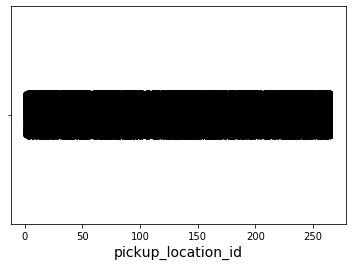

In [62]:
sns.stripplot(x=dfU15['pickup_location_id'], color='black')
plt.xlabel('pickup_location_id', fontsize=14)
plt.show()

**MTA data**

In [63]:
print(dfMTA.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554197 entries, 0 to 7554196
Data columns (total 11 columns):
station        object
line_name      object
division       object
audit_type     object
unit_id        object
datetime       object
new_entries    int64
new_exits      int64
latitude       float64
longitude      float64
Symbol         object
dtypes: float64(2), int64(2), object(7)
memory usage: 634.0+ MB
None


In [64]:
print(dfMTA.describe())

        new_entries     new_exits      latitude     longitude
count  7.554197e+06  7.554197e+06  7.554197e+06  7.554197e+06
mean   2.129277e+02  1.599114e+02  4.072606e+01 -7.394976e+01
std    2.493005e+02  2.134589e+02  6.815059e-02  5.788395e-02
min    1.000000e+00  1.000000e+00  4.057613e+01 -7.402840e+01
25%    3.500000e+01  2.600000e+01  4.068436e+01 -7.399336e+01
50%    1.230000e+02  8.000000e+01  4.072530e+01 -7.396850e+01
75%    2.970000e+02  2.050000e+02  4.075680e+01 -7.391656e+01
max    1.566000e+03  1.566000e+03  4.090313e+01 -7.375541e+01


In [65]:
print("null values in MTA data: \n ")
print(dfMTA.isna().sum())

null values in MTA data: 
 
station        0
line_name      0
division       0
audit_type     0
unit_id        0
datetime       0
new_entries    0
new_exits      0
latitude       0
longitude      0
Symbol         0
dtype: int64


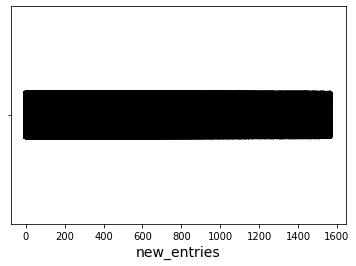

In [66]:
sns.stripplot(x=dfMTA['new_entries'], color='black')
plt.xlabel('new_entries', fontsize=14)
plt.show()

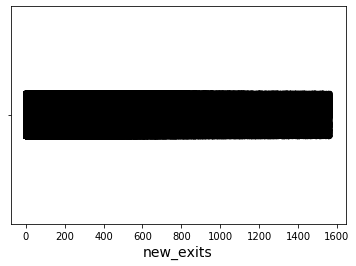

In [67]:
sns.stripplot(x=dfMTA['new_exits'], color='black')
plt.xlabel('new_exits', fontsize=14)
plt.show()

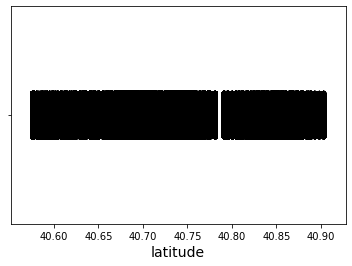

In [68]:
sns.stripplot(x=dfMTA['latitude'], color='black')
plt.xlabel('latitude', fontsize=14)
plt.show()

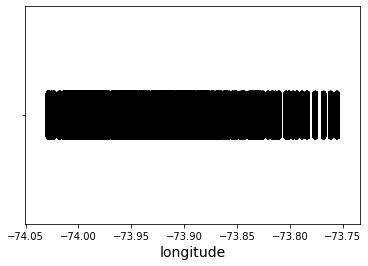

In [69]:
sns.stripplot(x=dfMTA['longitude'], color='black')
plt.xlabel('longitude', fontsize=14)
plt.show()